# Adding alkalinity to a ROMS initial file


In [1]:
import subprocess
import os

import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
from ocean_c_lab_tools import *
from roms_regrid import *

In [3]:
# import the initial file, x, and the grid

x=xr.open_dataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland4_BGC_copy/Iceland4_BGC_rst.20120622140000.nc')
zeta=x['zeta'].mean('time').values
t=x['temp'].values

grid=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/Iceland4_grd.nc')
h=grid['h'].values

pm=grid['pm'].values
pn=grid['pn'].values
mask_rho=grid['mask_rho'].values
;

''

In [4]:
#Define the location of the dye (line or center), it's radius, it's amplitude, tapering and cutt-off threshold.

amplitude = 1;
radius = 4;
cut=(1/128)
taper_hor=0.5
taper_vert=0.7
width=4
#length
line_outer = [1120];
line_inner = [1200];

line_down = 590;
line_up = 610;
#center4 = [1025, 610];

# Make empty variables for each dye
dye1=np.empty_like(t)*0


#set the initial amplitude

dye1[:,:,line_down:line_up,line_outer[0]-width:line_outer[0]+width]=amplitude


    #if np.max(dye1[:,:,j,:])<1/128:
     #   dye1[:,:,j,:]=0  
for i in np.arange((line_outer[0] - width-radius),(line_outer[0] - width)):
    distance=((i-(line_outer[0] - width))**2)**(1/2)
    dye1[:,:,:,i]=dye1[:,:,:,line_outer[0]]*0.5**distance
    #if np.max(dye1[:,:,:,i])<1/128:
       # dye1[:,:,:,i]=0
    

   # if np.max(dye1[:,:,j,:])<1/128:
     #   dye1[:,:,j,:]=0  


for i in np.arange((line_outer[0] + width),(line_outer[0] + width + radius)):
    distance=((i-(line_outer[0]+width))**2)**(1/2)
    dye1[:,:,:,i]=dye1[:,:,:,line_outer[0]]*0.5**distance
   # if np.max(dye1[:,:,:,i])<1/128:
      #  dye1[:,:,:,i]=0    

for i in np.arange((line_outer[0] - width),(line_outer[0] + width+1)):
    
    for j in np.arange((line_up),(line_up+radius)):
        distance=((j-(line_up))**2)**(1/2)
        dye1[:,:,j,i]=amplitude*0.5**distance
        
    for j in np.arange((line_down - radius),(line_down)):
        distance=((j-(line_down))**2)**(1/2)
        dye1[:,:,j,i]=amplitude*0.5**distance

for k in np.arange(0,100):
    dye1[:,k,:,:]=dye1[:,99,:,:]*0.7**abs((k-99))


In [5]:
# scale to number of IBCs

## calculating depth of each cell

# Sigma coordinate parameters
N = 100
theta_s = 5
theta_b = 2
hc = 300

k_w = np.linspace(0,N,N+1)
k_r = np.linspace(1,N,N)

sigma_w = (k_w - N) / N
sigma_r = (k_r - N - 0.5) / N

# Assuming that theta_s and theta_b are both > 0
# https://www.myroms.org/wiki/Vertical_S-coordinate

def Cs(sigma, theta_s, theta_b):
    C = ( 1 - np.cosh(theta_s * sigma) ) / (np.cosh(theta_s) - 1)
    C = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
    return C

Cs_w = Cs(sigma_w, theta_s, theta_b)
Cs_r = Cs(sigma_r, theta_s, theta_b)

S_w = np.zeros((N+1, h.shape[0], h.shape[1]))
S_r = np.zeros((N, h.shape[0], h.shape[1]))
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if mask_rho[i,j]:
            S_w[:,i,j] = (hc * sigma_w + h[i,j]*Cs_w) / (hc + h[i,j])
            S_r[:,i,j] = (hc * sigma_r + h[i,j]*Cs_r) / (hc + h[i,j])

# zeta is the sea surface height at any given time, here I am using an arbitrary zeta

file=xr.open_dataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland4_BGC_copy/Iceland4_BGC_rst.20120622140000.nc')
zeta=x['zeta'].mean('time').values

z_w = np.zeros((N+1, h.shape[0], h.shape[1]))
z_r = np.zeros((N, h.shape[0], h.shape[1]))

for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if mask_rho[i,j]:
            z_w[:,i,j] = zeta[i,j] + (zeta[i,j] + h[i,j])*S_w[:,i,j]
            z_r[:,i,j] = zeta[i,j] + (zeta[i,j] + h[i,j])*S_r[:,i,j]

cell_depths = np.zeros((N, h.shape[0], h.shape[1]))

for x in np.arange(1,101):
    cell_depths[x-1,:,:]=z_w[x,:,:]-z_w[x-1,:,:]
    

In [6]:

mass=dye1*1/pn*1/pm*cell_depths

total=np.sum(mass)


NaOH_test=7.5*10**3*1400*4


alk_scalar=NaOH_test*(1/total)
#(1/total) #moles/moles
alk_add=dye1*alk_scalar

In [10]:
alk_scalar

108.10444718440563

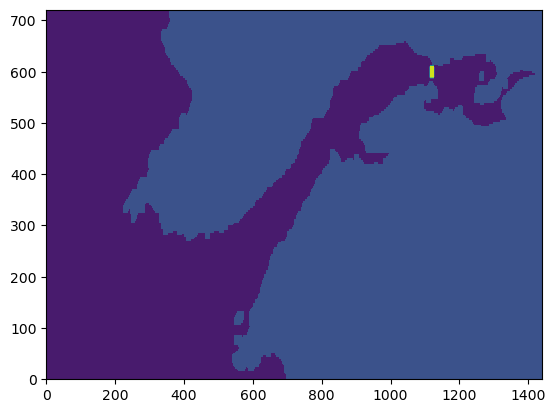

In [19]:
x=xr.open_dataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland4_BGC_copy/Iceland4_BGC_rst.20120622140000.nc')

plt.contourf(dye1[0,99,:,:])
plt.contourf(grid['mask_rho'].where(grid['mask_rho']<1))
#plt.xlim(975,1025)
#plt.ylim(500,700)

In [20]:

file['Alk']=file['Alk']+alk_add



#file['Alk']=(('time', 's_rho','eta_rho','xi_rho'),alk_new)




In [ ]:
file.to_netcdf('/expanse/lustre/projects/cos100/uheede/Iceland4_alk_addition.nc')